In [1]:
%matplotlib inline
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

from time import time
from copy import deepcopy

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())
sdss = sdss[sdss['z'] < 0.06]

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [3]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Volumes/simulation_data_2018/value_added_umachine_MDPl2_catalogs"
basename = "logsm_gt8_recolored_umachine_color_mock_v4.5_m000-499.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock['redshift'] = 0.
mock = mock[mock['obs_sm']>10**9]

mock.Lbox = 256.
print(mock.keys())

['source_halo_id', 'target_halo_id', 'target_halo_x', 'target_halo_y', 'target_halo_z', 'target_halo_vx', 'target_halo_vy', 'target_halo_vz', 'target_halo_mass', 'host_halo_mvir', 'upid', 'mpeak', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', 'x', 'vx', 'y', 'vy', 'z', 'vz', 'lightcone_id', 'redshift']


## Assign r-band magnitude

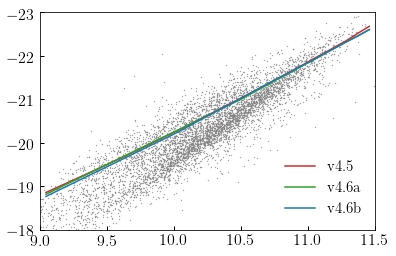

In [4]:
from cosmodc2.sdss_colors.broken_powerlaw_magr import median_magr_from_mstar
from cosmodc2.sdss_colors.broken_powerlaw_magr import magr_monte_carlo

kwargs = dict()
mock['mag_r'] = magr_monte_carlo(
    mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs)


from cosmodc2.sdss_colors.broken_powerlaw_magr import default2_m1_z0, default2_magr_at_m1_z0
from cosmodc2.sdss_colors.broken_powerlaw_magr import default2_beta_z0, default2_gamma_z0
# kwargs2 = dict(m1_z0=10., magr_at_m1_z0=-20.2, beta_z0=1.65, gamma_z0=1.5)
kwargs2 = dict(m1_z0=default2_m1_z0, magr_at_m1_z0=default2_magr_at_m1_z0, 
               beta_z0=default2_beta_z0, gamma_z0=default2_gamma_z0)
mock['new_mag_r'] = magr_monte_carlo(
    mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs2)



fig, ax = plt.subplots(1, 1)

nskip = 10
__=ax.scatter(sdss['sm'][::nskip], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip], 
              s=0.1, color='gray', label='')

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 11.5, 30)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
v4p5_median_magr, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['restframe_extincted_sdss_abs_magr'], 
    bins=logsm_bins, statistic='median')
v4p6a_median_magr, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['mag_r'], 
    bins=logsm_bins, statistic='median')
v4p6b_median_magr, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['new_mag_r'], 
    bins=logsm_bins, statistic='median')


__=ax.plot(logsm_mids, v4p5_median_magr, color=mred, label=r'${\rm v4.5}$')
__=ax.plot(logsm_mids, v4p6a_median_magr, color=mgreen, label=r'${\rm v4.6a}$')
__=ax.plot(logsm_mids, v4p6b_median_magr, color=mblue, label=r'${\rm v4.6b}$')
leg = ax.legend()
xlim = ax.set_xlim(9, 11.5)
ylim = ax.set_ylim(-18, -23)

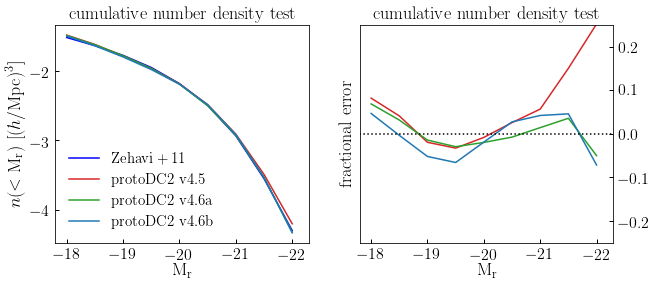

In [5]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = mock.Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4p5 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4p6a = cumulative_nd(mock['mag_r'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4p6b = cumulative_nd(mock['new_mag_r'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color='blue')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p5), 
            label=r'${\rm protoDC2\ v4.5}$', color=mred)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p6a), 
            label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p6b), 
            label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

fracdiff_pdc2_v4p5 = (cumnd_pdc2_v4p5 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4p6a = (cumnd_pdc2_v4p6a - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4p6b = (cumnd_pdc2_v4p6b - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p5, 
            label=r'${\rm protoDC2\ v4.5}$', color=mred)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p6a, 
            label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p6b, 
            label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm cumulative\ number\ density\ test}$')
title2 = ax2.set_title(r'${\rm cumulative\ number\ density\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-17.8, -22.3)
ylim2 = ax2.set_ylim(-0.25, 0.25)


In [ ]:
# kwargs_alt2 = {}
# for key in kwargs_alt.keys():
#     kwargs_alt2[key] = models[key][0]

In [ ]:
# from cosmodc2.sdss_colors.analytical_magr import median_magr_from_mstar, magr_monte_carlo

# kwargs_alt = dict(beta_z0=2.85, magr_at_m1_z0=-20.2, 
#               gamma_z0=2.25, m1=10.)
# mock['mag_r'] = magr_monte_carlo(
#     mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs_alt)

# kwargs_alt2 = dict(beta_z0=2.8, magr_at_m1_z0=-20.2, 
#               gamma_z0=2.5, m1=10.)
# mock['new_mag_r'] = magr_monte_carlo(
#     mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs_alt2)

In [ ]:
def magr(mstar, upid, redshift, m1, magr_at_m1_z0, gamma, beta, dm1=0.15):
    mstar = np.atleast_1d(mstar)
    x = mstar/10.**m1
    logsm = np.log10(mstar)
    logx = np.log10(x)

    slope = np.zeros_like(logx)
    low_mass_mask = logsm < m1 - dm1
    mid_mass_mask = (logsm >= m1-dm1) & (logsm < m1+dm1)
    high_mass_mask = logsm >= m1 + dm1

    if np.count_nonzero(low_mass_mask) > 0:
        slope[low_mass_mask] = gamma
    if np.count_nonzero(mid_mass_mask) > 0:
        slope[mid_mass_mask] = np.interp(
            logsm[mid_mass_mask], [m1-dm1, m1+dm1], [gamma, beta])
    if np.count_nonzero(high_mass_mask) > 0:
        slope[high_mass_mask] = beta
    
    result = -slope*logx + magr_at_m1_z0
    return result

def mc_magr(mstar, upid, redshift, m1, magr_at_m1_z0, gamma, beta, dm1=0.15):
    median_magr = magr(mstar, upid, redshift, m1, magr_at_m1_z0, gamma, beta, dm1=dm1)
    return np.random.normal(loc=median_magr, scale=0.2)

In [ ]:
mstar_array = np.logspace(8, 12, 1000)

m1 = 10.5
magr_at_m1_z0 = -21
gamma = 1.6
beta = 1.65
mock['mag_r'] = mc_magr(mock['obs_sm'], mock['upid'], mock['redshift'], 
                       m1, magr_at_m1_z0, gamma, beta)
median_magr1 = magr(mstar_array, None, None, m1, magr_at_m1_z0, gamma, beta)

m1 = 10.5
magr_at_m1_z0 = -21
gamma = 1.6
beta = 1.65
mock['new_mag_r'] = mc_magr(mock['obs_sm'], mock['upid'], mock['redshift'], 
                       m1, magr_at_m1_z0, gamma, beta)
median_magr2 = magr(mstar_array, None, None, m1, magr_at_m1_z0, gamma, beta)


fig, ax = plt.subplots(1, 1)

nskip = 10
__=ax.scatter(sdss['sm'][::nskip], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip], s=0.1)

__=ax.plot(np.log10(mstar_array), median_magr1, color='k')
__=ax.plot(np.log10(mstar_array), median_magr2, color=morange)


from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 11.5, 30)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
v4p5_median_magr, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['restframe_extincted_sdss_abs_magr'], 
    bins=logsm_bins, statistic='median')

__=ax.plot(logsm_mids, v4p5_median_magr, color=mred)
xlim = ax.set_xlim(9, 11.5)
ylim = ax.set_ylim(-18, -23)

In [ ]:
binned_statistic?

In [ ]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = mock.Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4p5 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4p6a = cumulative_nd(mock['mag_r'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4p6b = cumulative_nd(mock['new_mag_r'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color='blue')
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p5), 
            label=r'${\rm protoDC2\ v4.5}$', color=mred)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p6a), 
            label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p6b), 
            label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

fracdiff_pdc2_v4p5 = (cumnd_pdc2_v4p5 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4p6a = (cumnd_pdc2_v4p6a - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4p6b = (cumnd_pdc2_v4p6b - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p5, 
            label=r'${\rm protoDC2\ v4.5}$', color=mred)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p6a, 
            label=r'${\rm protoDC2\ v4.6a}$', color=mgreen)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p6b, 
            label=r'${\rm protoDC2\ v4.6b}$', color=mblue)

__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm cumulative\ number\ density\ test}$')
title2 = ax2.set_title(r'${\rm cumulative\ number\ density\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-17.8, -22.3)
ylim2 = ax2.set_ylim(-0.3, 0.3)


In [ ]:
# from cosmodc2.sdss_colors.new_analytical_magr import median_magr_from_mstar, magr_monte_carlo

# from astropy.table import Table
# model_results = Table.read('parameter_scan2.hdf5', path='data')
# model_results.sort('chisq')

# default_params = dict(
#     m1=10., magr_at_m1_z0=-20.2, 
#     beta_z0=2.85, gamma_z0=2.25)
# print("old = {0}".format(default_params))

# kwargs_alt = {'gamma_z0': 2.3, 'beta_z0': 2.88, 'm1': 10.25, 'magr_at_m1_z0': -20.6}
# kwargs_alt2 = {}
# itest1, itest2 = 0, 4
# for key in default_params.keys():
#     kwargs_alt[key] = model_results[key][itest1]
#     kwargs_alt2[key] = model_results[key][itest2]
    
# mock['mag_r'] = magr_monte_carlo(
#     mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs_alt)

# # kwargs_alt2 = deepcopy(kwargs_alt)
# # kwargs_alt2['beta_z0'] = 2.8
# # kwargs_alt2['gamma_z0'] = 2.75
# # kwargs_alt2['m1'] = 10.5
# # kwargs_alt2['magr_at_m1_z0'] = -20
# print("new = {0}".format(kwargs_alt2))
# mock['new_mag_r'] = magr_monte_carlo(
#     mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs_alt2)

In [ ]:
# m1 = 10.5
# magr_at_m1_z0 = -20.8
# gamma = 2
# beta = 2.2
# mock['mag_r'] = mc_magr(mock['obs_sm'], mock['upid'], mock['redshift'], 
#                        m1, magr_at_m1_z0, gamma, beta)


# m1 = 10.5
# magr_at_m1_z0 = -21
# gamma = 2.25
# beta = 2.4
# mock['new_mag_r'] = mc_magr(mock['obs_sm'], mock['upid'], mock['redshift'], 
#                        m1, magr_at_m1_z0, gamma, beta)





In [ ]:
np.sqrt(np.sum(fracdiff_pdc2_v4p6b**2))

In [ ]:
# from cosmodc2.sdss_colors import zehavi11_cumulative_nd
# lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

# from cosmodc2.mock_diagnostics import cumulative_nd
# volume_v4 = mock.Lbox**3.
# protoDC2_littleh = 0.7


# default_params = dict(
#     m1=10., magr_at_m1_z0=-20.2, 
#     beta_z0=2.85, gamma_z0=2.25)

# npts_m1 = 5
# npts_norm = 10
# npts_beta = 5
# npts_gamma = 5
# npts_total = npts_m1*npts_norm*npts_beta*npts_gamma
# msg = "Estimated runtime = {0:.1f} seconds = {1:.2f} minutes"
# print(msg.format(npts_total*0.15, npts_total*0.15/60.))

# dm1 = 0.2
# dnorm = 0.25
# dbeta = 0.3
# dgamma = 0.2
# m1_arr = np.linspace(default_params['m1']-dm1, default_params['m1']+dm1, npts_m1)
# gamma_arr = np.linspace(
#     default_params['gamma_z0']-dgamma, default_params['gamma_z0']+dgamma, npts_gamma)
# beta_arr = np.linspace(
#     default_params['beta_z0']-dbeta, default_params['beta_z0']+dbeta, npts_beta)
# norm_arr = np.linspace(
#     default_params['magr_at_m1_z0']-dnorm, default_params['magr_at_m1_z0']+dnorm, npts_norm)

# from astropy.table import Table
# models = Table()
# models['m1'] = np.zeros(npts_total)
# models['gamma_z0'] = np.zeros(npts_total)
# models['beta_z0'] = np.zeros(npts_total)
# models['magr_at_m1_z0'] = np.zeros(npts_total)
# # models['fracdiff'] = np.zeros((npts_total, 9))
# models['chisq'] = np.zeros(npts_total)

# from itertools import product


# start = time()
# icounter = 0
# for m1, gamma_z0, beta_z0, magr_at_m1_z0 in product(m1_arr, gamma_arr, beta_arr, norm_arr):
#     kwargs = dict(m1=m1, gamma_z0=gamma_z0, beta_z0=beta_z0, magr_at_m1_z0=magr_at_m1_z0)
#     mag_r = magr_monte_carlo(mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs)
#     cumnd = cumulative_nd(mag_r, volume_v4, protoDC2_littleh, lumthresh_h1p0)
#     fracdiff = (cumnd - cumnd_sdss)/cumnd_sdss
#     for key, value in kwargs.items():
#         models[key][icounter] = value
# #     models[icounter]['fracdiff'] = fracdiff
#     models['chisq'][icounter] = np.sqrt(np.sum(fracdiff**2))
#     icounter += 1
# end = time()
# runtime = end - start
# print("Total runtime = {0:.2f} seconds for {1} models".format(runtime, icounter))
# runtime_per_model = runtime/float(icounter)
# print("Runtime per evaluation = {0:.2f} seconds".format(runtime_per_model))




In [ ]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd
volume_v4 = mock.Lbox**3.
protoDC2_littleh = 0.7

default_params = dict(
    m1=10., magr_at_m1_z0=-20.2, 
    beta_z0=2.85, gamma_z0=2.25)

npts_norm = 30
npts_beta = 30
npts_total = npts_norm*npts_beta
msg = "Estimated runtime for {0} evaluations = {1:.1f} seconds = {2:.2f} minutes"
print(msg.format(npts_total, npts_total*0.15, npts_total*0.15/60.))

dnorm = 0.15
dbeta = 0.2
beta_center = 2.7
norm_center = -21
beta_arr = np.linspace(beta_center-dbeta, beta_center+dbeta, npts_beta)
norm_arr = np.linspace(norm_center-dnorm, norm_center+dnorm, npts_norm)

from astropy.table import Table
models = Table()
models['m1'] = np.zeros(npts_total)
models['gamma_z0'] = np.zeros(npts_total)
models['beta_z0'] = np.zeros(npts_total)
models['magr_at_m1_z0'] = np.zeros(npts_total)
models['chisq'] = np.zeros(npts_total)

from itertools import product

start = time()
icounter = 0
for beta_z0, magr_at_m1_z0 in product(beta_arr, norm_arr):
    gamma_z0 = 2.75
    m1 = 10.5
    kwargs = dict(m1=m1, gamma_z0=gamma_z0, beta_z0=beta_z0, magr_at_m1_z0=magr_at_m1_z0)
    mag_r = magr_monte_carlo(mock['obs_sm'], mock['upid'], mock['redshift'], **kwargs)
    cumnd = cumulative_nd(mag_r, volume_v4, protoDC2_littleh, lumthresh_h1p0)
    fracdiff = (cumnd - cumnd_sdss)/cumnd_sdss
    for key, value in kwargs.items():
        models[key][icounter] = value
    models['chisq'][icounter] = np.sqrt(np.sum(fracdiff**2))
    icounter += 1
end = time()
runtime = end - start
print("Total runtime = {0:.2f} seconds for {1} models".format(runtime, icounter))
runtime_per_model = runtime/float(icounter)
print("Runtime per evaluation = {0:.2f} seconds".format(runtime_per_model))


In [ ]:
models.sort('chisq')
models[:10]

In [ ]:
models.write('parameter_scan2.hdf5', path='data', overwrite=True)